# Add cell type

In [74]:
# Import packages
import os
import sys
import glob
import numpy as np
import pandas as pd
import scanpy as sc
import decoupler as dc
import snapatac2 as snap
import scipy.stats as stats
sc.settings.verbosity = 0

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

In [168]:
# File paths
h5ads_path = "/cellar/users/aklie/data/datasets/Chiou2021_islet_snATAC-seq/results/integration/atac/merged.h5ads"
outdir_path = "/cellar/users/aklie/data/datasets/Chiou2021_islet_snATAC-seq/results/integration/atac"

# 
cell_annotations_path = "/cellar/users/aklie/data/datasets/Chiou2021_islet_snATAC-seq/ref/publication/islet.cluster_labels.txt"
cell_qc_path = "/cellar/users/aklie/data/datasets/Chiou2021_islet_snATAC-seq/ref/publication/islet.qc_metrics.txt"
sample_metadata_path = "/cellar/users/aklie/data/datasets/Chiou2021_islet_snATAC-seq/metadata/sample_metadata.tsv"
blacklist_path = "/cellar/users/aklie/data/ref/genomes/hg38/blacklist/blacklist.bed.gz"
cellid_colors_path = "/cellar/users/aklie/data/datasets/Chiou2021_islet_snATAC-seq/ref/cellid_colors.csv"
sample_id_mapping_path = "/cellar/users/aklie/data/datasets/Chiou2021_islet_snATAC-seq/ref/publication/id_mapping.txt"

# Make output directory
os.makedirs(outdir_path, exist_ok=True)
     

In [169]:
# Load cell id colors
cellid_colors = pd.read_csv(cellid_colors_path, index_col=0, header=None)
cellid_colors = cellid_colors.to_dict()[1]
cellid_colors

{'beta_1': '#0d8101',
 'beta_2': '#00ff00',
 'alpha_1': '#8b1200',
 'alpha_2': '#ff0000',
 'delta_1': '#fd8e02',
 'delta_2': '#ff7f00',
 'gamma': '#800780',
 'epsilon': '#b360cf',
 'ductal': '#a7a7a7',
 'acinar': '#010101',
 'stellate': '#88ccea',
 'activated_stellate': '#4a91c7',
 'quescient_stellate': '#c0e4f3',
 'endothelial': '#5077e0',
 'schwann': '#f4ca16',
 'mast': '#ff6347',
 'immune': '#0700ff',
 'other': '#ff00ff'}

In [170]:
# Load sample mapping
sample_id_mapping = pd.read_csv(sample_id_mapping_path, index_col=1)
sample_id_mapping["donor id"] = sample_id_mapping["donor id"].str.replace(":", "_")
sample_id_mapping = sample_id_mapping.to_dict()["donor id"]
sample_id_mapping

{'Islet1': 'UNOS_AFC2208',
 'Islet2': 'UNOS_AFEA331',
 'Islet3': 'UNOS_AFEP022',
 'Pancreas1': 'nPOD_6004'}

## Load h5ads

In [171]:
# Read in h5ad file
adataset = snap.read_dataset(h5ads_path)
adata = adataset.to_adata()
adataset.close()
adata

AnnData object with n_obs × n_vars = 13859 × 606219
    obs: 'sample', 'log_n_fragment', 'tsse', 'leiden_1'
    var: 'count', 'selected'
    uns: 'AnnDataSet', 'reference_sequences', 'spectral_eigenvalue'
    obsm: 'X_spectral', 'X_umap'
    obsp: 'distances'

## Load and merge sample metadata

In [172]:
# Load and inspect sample metadata
sample_metadata = pd.read_csv(sample_metadata_path, sep="\t")
sample_metadata.head()

,donor_id,tissue,sex,age,bmi
0,UNOS_AFC2208,pancreatic islets,male,32,32.3
1,UNOS_AFEA331,pancreatic islets,male,45,29.3
2,UNOS_AFEP022,pancreatic islets,male,62,36.1
3,nPOD_6004_CB,whole pancreas,male,33,30.9
4,nPOD_6004_10x,whole pancreas,male,33,30.9


In [173]:
# Merge metadata
bcs = adata.obs.index.tolist()
adata_obs = adata.obs.merge(sample_metadata, left_on="sample", right_on="donor_id")
adata_obs.index = bcs
adata.obs = adata_obs
adata.obs.head()

,sample,log_n_fragment,tsse,leiden_1,donor_id,tissue,sex,age,bmi
UNOS_AFC2208#AGACACCTAAGAGGCAAAGGAGTACCTAT,UNOS_AFC2208,3.423737,29.249012,1,UNOS_AFC2208,pancreatic islets,male,32,32.3
UNOS_AFC2208#AGACACCTAAGAGGCAAAGGAGTAGGCTC,UNOS_AFC2208,3.518646,20.718816,4,UNOS_AFC2208,pancreatic islets,male,32,32.3
UNOS_AFC2208#AGACACCTAAGAGGCAAAGGAGTAGGTTG,UNOS_AFC2208,3.662380,28.423978,4,UNOS_AFC2208,pancreatic islets,male,32,32.3
UNOS_AFC2208#AGACACCTAAGAGGCAAAGGCTATATAGA,UNOS_AFC2208,3.302980,16.042781,9,UNOS_AFC2208,pancreatic islets,male,32,32.3
UNOS_AFC2208#AGACACCTAAGAGGCAACTGCATAGTACT,UNOS_AFC2208,4.119190,22.744959,3,UNOS_AFC2208,pancreatic islets,male,32,32.3


## Load refined cell metadata

In [174]:
# Grab more refined cell metadata
sample_dir = "/cellar/users/aklie/data/datasets/Chiou2021_islet_snATAC-seq/results/sample_annotation"
sample_files = glob.glob(os.path.join(sample_dir, "*/atac/snapatac2/cell_metadata.tsv"))
cell_metadata = pd.concat([pd.read_csv(f, sep="\t", index_col=0) for f in sample_files])
cell_metadata

,n_fragment,frac_dup,frac_mito,tsse,log_n_fragment,doublet_probability,doublet_score,leiden_1
nPOD_6004_CB#AACGAGAGCTAACGTGATTTGG,1070,0.729638,0.037770,25.852273,3.029789,0.184137,0.004899,1
nPOD_6004_CB#AACGAGAGCTAAGCGCCATCGA,1309,0.711799,0.023863,28.138528,3.117271,0.194246,0.000653,1
nPOD_6004_CB#AACGAGAGCTAAGCTAACGCAC,1279,0.659622,0.164052,12.807318,3.107210,0.127212,0.052632,1
nPOD_6004_CB#AACGAGAGCTAAGGGCAAATCA,2321,0.650012,0.209199,12.440191,3.365862,0.168530,0.012539,1
nPOD_6004_CB#AACGAGAGCTAATCGCTGGATG,1192,0.701167,0.009967,24.441133,3.076640,0.192583,0.001321,1
...,...,...,...,...,...,...,...,...
UNOS_AFC2208#TCCGGAGATGCAGCTATCTCTCCGATAGA,1754,0.724733,0.000000,29.725830,3.244277,0.162695,0.013699,4
UNOS_AFC2208#TCCGGAGATGCAGCTATTATGCGAGGCTC,6161,0.794176,0.000325,26.535627,3.789722,0.124903,0.042720,3
UNOS_AFC2208#TCCGGAGATGCAGCTATTATGCGAGGTTG,2229,0.765065,0.017629,26.403162,3.348305,0.152894,0.018617,0
UNOS_AFC2208#TCCGGAGATGCAGCTATTCTAGCTCCTAT,4119,0.782138,0.001455,20.959596,3.614897,0.120802,0.054475,1


In [175]:
num_with_metadata = adata.obs.index.isin(cell_metadata.index).sum()
print(f"Number of cells with metadata: {num_with_metadata} ({num_with_metadata/adata.n_obs*100:.2f}%)")

Number of cells with metadata: 13859 (100.00%)


In [176]:
# Merge cell metadata columns frac_dup frac_mito doublet_probability doublet_score
adata.obs = adata.obs.merge(cell_metadata[['n_fragment', 'frac_dup', 'frac_mito', 'doublet_probability', 'doublet_score']], left_index=True, right_index=True, how="left")
adata.obs.head()

,sample,log_n_fragment,tsse,leiden_1,donor_id,tissue,sex,age,bmi,n_fragment,frac_dup,frac_mito,doublet_probability,doublet_score
UNOS_AFC2208#AGACACCTAAGAGGCAAAGGAGTACCTAT,UNOS_AFC2208,3.423737,29.249012,1,UNOS_AFC2208,pancreatic islets,male,32,32.3,2652,0.763982,0.046386,0.146618,0.022284
UNOS_AFC2208#AGACACCTAAGAGGCAAAGGAGTAGGCTC,UNOS_AFC2208,3.518646,20.718816,4,UNOS_AFC2208,pancreatic islets,male,32,32.3,3300,0.772934,0.041534,0.125820,0.041237
UNOS_AFC2208#AGACACCTAAGAGGCAAAGGAGTAGGTTG,UNOS_AFC2208,3.662380,28.423978,4,UNOS_AFC2208,pancreatic islets,male,32,32.3,4595,0.778682,0.000000,0.257358,0.129032
UNOS_AFC2208#AGACACCTAAGAGGCAAAGGCTATATAGA,UNOS_AFC2208,3.302980,16.042781,9,UNOS_AFC2208,pancreatic islets,male,32,32.3,2008,0.736175,0.072946,0.133773,0.031956
UNOS_AFC2208#AGACACCTAAGAGGCAACTGCATAGTACT,UNOS_AFC2208,4.119190,22.744959,3,UNOS_AFC2208,pancreatic islets,male,32,32.3,13157,0.787660,0.000000,0.157354,0.098782


## Load cell annotations

In [177]:
# Add in cell annotation
cell_annotations = pd.read_csv(cell_annotations_path, sep="\t", index_col=0)
cell_annotations["sample_id"] = cell_annotations.index.str.split("_").str[0]
cell_annotations["barcode"] = cell_annotations.index.str.split("_").str[1]
cell_annotations["donor_id"] = cell_annotations["sample_id"].map(sample_id_mapping)
cell_annotations.index = cell_annotations["donor_id"] + "#" + cell_annotations["barcode"]
cell_annotations

,UMAP1,UMAP2,cluster_name,sample_id,barcode,donor_id
UNOS_AFC2208#AGACACCTAAGAGGCAAAGGAGTAGGCTC,-5.102393,1.386820,alpha_2,Islet1,AGACACCTAAGAGGCAAAGGAGTAGGCTC,UNOS_AFC2208
UNOS_AFC2208#AGACACCTAAGAGGCAAAGGAGTAGGTTG,2.121361,3.553382,beta_2,Islet1,AGACACCTAAGAGGCAAAGGAGTAGGTTG,UNOS_AFC2208
UNOS_AFC2208#AGACACCTAAGAGGCAAAGGCTATATAGA,2.089698,10.069536,immune,Islet1,AGACACCTAAGAGGCAAAGGCTATATAGA,UNOS_AFC2208
UNOS_AFC2208#AGACACCTAAGAGGCAACTGCATAGTACT,-9.805659,1.126913,alpha_1,Islet1,AGACACCTAAGAGGCAACTGCATAGTACT,UNOS_AFC2208
UNOS_AFC2208#AGACACCTAAGAGGCACCTAGAGTAGGCG,8.333635,-0.719022,beta_1,Islet1,AGACACCTAAGAGGCACCTAGAGTAGGCG,UNOS_AFC2208
...,...,...,...,...,...,...
UNOS_AFEP022#TCCGGAGATGCAGCTATATCCTCTTATAGCCT,-8.929577,-0.903379,alpha_1,Islet3,TCCGGAGATGCAGCTATATCCTCTTATAGCCT,UNOS_AFEP022
UNOS_AFEP022#TCCGGAGATGCAGCTATCGACTAGATAGAGGC,9.970760,-1.262243,beta_1,Islet3,TCCGGAGATGCAGCTATCGACTAGATAGAGGC,UNOS_AFEP022
UNOS_AFEP022#TCCGGAGATGCAGCTATCTCTCCGATAGAGGC,8.195073,-3.274887,beta_1,Islet3,TCCGGAGATGCAGCTATCTCTCCGATAGAGGC,UNOS_AFEP022
UNOS_AFEP022#TCCGGAGATGCAGCTATTCTAGCTCAGGACGT,-8.613805,-1.172882,alpha_1,Islet3,TCCGGAGATGCAGCTATTCTAGCTCAGGACGT,UNOS_AFEP022


In [178]:
num_annotated = adata.obs.index.isin(cell_annotations.index).sum()
print(f"Number of annotated cells: {num_annotated} ({num_annotated/adata.n_obs*100:.2f}%)")

Number of annotated cells: 12806 (92.40%)


In [179]:
# Merge annotations columns UMAP1	UMAP2	cluster_name	sample_id	barcode
adata.obs = adata.obs.merge(cell_annotations[['UMAP1', 'UMAP2', 'cluster_name', 'sample_id', 'barcode']], left_index=True, right_index=True, how="left")
adata.obs.head()

,sample,log_n_fragment,tsse,leiden_1,donor_id,tissue,sex,age,bmi,n_fragment,frac_dup,frac_mito,doublet_probability,doublet_score,UMAP1,UMAP2,cluster_name,sample_id,barcode
UNOS_AFC2208#AGACACCTAAGAGGCAAAGGAGTACCTAT,UNOS_AFC2208,3.423737,29.249012,1,UNOS_AFC2208,pancreatic islets,male,32,32.3,2652,0.763982,0.046386,0.146618,0.022284,NaN,NaN,NaN,NaN,NaN
UNOS_AFC2208#AGACACCTAAGAGGCAAAGGAGTAGGCTC,UNOS_AFC2208,3.518646,20.718816,4,UNOS_AFC2208,pancreatic islets,male,32,32.3,3300,0.772934,0.041534,0.125820,0.041237,-5.102393,1.386820,alpha_2,Islet1,AGACACCTAAGAGGCAAAGGAGTAGGCTC
UNOS_AFC2208#AGACACCTAAGAGGCAAAGGAGTAGGTTG,UNOS_AFC2208,3.662380,28.423978,4,UNOS_AFC2208,pancreatic islets,male,32,32.3,4595,0.778682,0.000000,0.257358,0.129032,2.121361,3.553382,beta_2,Islet1,AGACACCTAAGAGGCAAAGGAGTAGGTTG
UNOS_AFC2208#AGACACCTAAGAGGCAAAGGCTATATAGA,UNOS_AFC2208,3.302980,16.042781,9,UNOS_AFC2208,pancreatic islets,male,32,32.3,2008,0.736175,0.072946,0.133773,0.031956,2.089698,10.069536,immune,Islet1,AGACACCTAAGAGGCAAAGGCTATATAGA
UNOS_AFC2208#AGACACCTAAGAGGCAACTGCATAGTACT,UNOS_AFC2208,4.119190,22.744959,3,UNOS_AFC2208,pancreatic islets,male,32,32.3,13157,0.787660,0.000000,0.157354,0.098782,-9.805659,1.126913,alpha_1,Islet1,AGACACCTAAGAGGCAACTGCATAGTACT


## Load cell QC from paper and merge

In [180]:
# Load in paper cell qc
cell_qc = pd.read_csv(cell_qc_path, sep="\t", index_col=0)
cell_qc["sample_id"] = cell_qc.index.str.split("_").str[0]
cell_qc["barcode"] = cell_qc.index.str.split("_").str[1]
cell_qc["donor_id"] = cell_qc["sample_id"].map(sample_id_mapping)
cell_qc.index = cell_qc["donor_id"] + "#" + cell_qc["barcode"]
cell_qc

,duplicated_reads,total_sequenced_reads,unique_usable_reads,unique_mito_reads,reads_in_peaks,reads_in_promoters,tss_used,frac_reads_in_peaks,frac_reads_in_promoters,frac_promoters_used,frac_mito_reads,frac_duplicated_reads,sample_id,barcode,donor_id
UNOS_AFC2208#AGACACCTAAGAGGCAAAGGAGTAAGGCG,0,12,12,0,12,6,3,1.000000,0.500000,0.000148,0.000000,0.000000,Islet1,AGACACCTAAGAGGCAAAGGAGTAAGGCG,UNOS_AFC2208
UNOS_AFC2208#AGACACCTAAGAGGCAAAGGAGTAATAGA,38,54,16,0,10,4,2,0.625000,0.250000,0.000099,0.000000,0.703704,Islet1,AGACACCTAAGAGGCAAAGGAGTAATAGA,UNOS_AFC2208
UNOS_AFC2208#AGACACCTAAGAGGCAAAGGAGTACAGGA,32,36,4,0,0,0,0,0.000000,0.000000,0.000000,0.000000,0.888889,Islet1,AGACACCTAAGAGGCAAAGGAGTACAGGA,UNOS_AFC2208
UNOS_AFC2208#AGACACCTAAGAGGCAAAGGAGTACCTAT,18596,23652,4860,196,2705,1070,552,0.556584,0.220165,0.027270,0.038766,0.786234,Islet1,AGACACCTAAGAGGCAAAGGAGTACCTAT,UNOS_AFC2208
UNOS_AFC2208#AGACACCTAAGAGGCAAAGGAGTAGGCTC,24406,30882,6254,222,3739,1655,878,0.597857,0.264631,0.043375,0.034280,0.790299,Islet1,AGACACCTAAGAGGCAAAGGAGTAGGCTC,UNOS_AFC2208
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
UNOS_AFEP022#TCCGGAGATGCAGCTATTCTAGCTCAGGACGT,3202,5940,2736,2,2267,998,552,0.707995,0.311680,0.027270,0.000624,0.460606,Islet3,TCCGGAGATGCAGCTATTCTAGCTCAGGACGT,UNOS_AFEP022
UNOS_AFEP022#TCCGGAGATGCAGCTATTCTAGCTCCTATCCT,8426,15876,7446,4,6834,3390,1770,0.811061,0.402326,0.087442,0.000474,0.469010,Islet3,TCCGGAGATGCAGCTATTCTAGCTCCTATCCT,UNOS_AFEP022
UNOS_AFEP022#TCCGGAGATGCAGCTATTCTAGCTGGTTGCGT,2,6,4,0,2,0,0,1.000000,0.000000,0.000000,0.000000,0.666667,Islet3,TCCGGAGATGCAGCTATTCTAGCTGGTTGCGT,UNOS_AFEP022
UNOS_AFEP022#TCCGGAGATGCAGCTATTCTAGCTGTACTGAC,22,54,24,8,15,10,5,0.681818,0.454545,0.000247,0.266667,0.444444,Islet3,TCCGGAGATGCAGCTATTCTAGCTGTACTGAC,UNOS_AFEP022


In [181]:
num_with_qc = adata.obs.index.isin(cell_qc.index).sum()
print(f"Number of cells with qc: {num_with_qc} ({num_with_qc/adata.n_obs*100:.2f}%)")

Number of cells with qc: 13859 (100.00%)


In [182]:
# Merge qc columns
adata.obs = adata.obs.merge(cell_qc, left_index=True, right_index=True, how="left", suffixes=("", "_paper_qc"))
adata.obs

,sample,log_n_fragment,tsse,leiden_1,donor_id,tissue,sex,age,bmi,n_fragment,...,reads_in_promoters,tss_used,frac_reads_in_peaks,frac_reads_in_promoters,frac_promoters_used,frac_mito_reads,frac_duplicated_reads,sample_id_paper_qc,barcode_paper_qc,donor_id_paper_qc
UNOS_AFC2208#AGACACCTAAGAGGCAAAGGAGTACCTAT,UNOS_AFC2208,3.423737,29.249012,1,UNOS_AFC2208,pancreatic islets,male,32,32.3,2652,...,1070,552,0.556584,0.220165,0.027270,0.038766,0.786234,Islet1,AGACACCTAAGAGGCAAAGGAGTACCTAT,UNOS_AFC2208
UNOS_AFC2208#AGACACCTAAGAGGCAAAGGAGTAGGCTC,UNOS_AFC2208,3.518646,20.718816,4,UNOS_AFC2208,pancreatic islets,male,32,32.3,3300,...,1655,878,0.597857,0.264631,0.043375,0.034280,0.790299,Islet1,AGACACCTAAGAGGCAAAGGAGTAGGCTC,UNOS_AFC2208
UNOS_AFC2208#AGACACCTAAGAGGCAAAGGAGTAGGTTG,UNOS_AFC2208,3.662380,28.423978,4,UNOS_AFC2208,pancreatic islets,male,32,32.3,4595,...,4226,2061,0.808279,0.474086,0.101818,0.000000,0.785927,Islet1,AGACACCTAAGAGGCAAAGGAGTAGGTTG,UNOS_AFC2208
UNOS_AFC2208#AGACACCTAAGAGGCAAAGGCTATATAGA,UNOS_AFC2208,3.302980,16.042781,9,UNOS_AFC2208,pancreatic islets,male,32,32.3,2008,...,1067,535,0.414582,0.283928,0.026430,0.059089,0.766760,Islet1,AGACACCTAAGAGGCAAAGGCTATATAGA,UNOS_AFC2208
UNOS_AFC2208#AGACACCTAAGAGGCAACTGCATAGTACT,UNOS_AFC2208,4.119190,22.744959,3,UNOS_AFC2208,pancreatic islets,male,32,32.3,13157,...,8059,3536,0.704130,0.320616,0.174686,0.000000,0.793659,Islet1,AGACACCTAAGAGGCAACTGCATAGTACT,UNOS_AFC2208
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
UNOS_AFEP022#TCCGGAGATGCAGCTACTCTCTATTATAGCCT,UNOS_AFEP022,3.952163,21.628372,2,UNOS_AFEP022,pancreatic islets,male,62,36.1,8956,...,5548,2650,0.761781,0.319622,0.130916,0.013974,0.478832,Islet3,TCCGGAGATGCAGCTACTCTCTATTATAGCCT,UNOS_AFEP022
UNOS_AFEP022#TCCGGAGATGCAGCTATATCCTCTTATAGCCT,UNOS_AFEP022,3.543074,27.201145,2,UNOS_AFEP022,pancreatic islets,male,62,36.1,3491,...,2296,1180,0.802288,0.341058,0.058295,0.107162,0.432400,Islet3,TCCGGAGATGCAGCTATATCCTCTTATAGCCT,UNOS_AFEP022
UNOS_AFEP022#TCCGGAGATGCAGCTATCGACTAGATAGAGGC,UNOS_AFEP022,3.130655,31.432974,0,UNOS_AFEP022,pancreatic islets,male,62,36.1,1350,...,1123,614,0.812117,0.430598,0.030333,0.073205,0.478309,Islet3,TCCGGAGATGCAGCTATCGACTAGATAGAGGC,UNOS_AFEP022
UNOS_AFEP022#TCCGGAGATGCAGCTATTCTAGCTCAGGACGT,UNOS_AFEP022,3.221153,19.277108,2,UNOS_AFEP022,pancreatic islets,male,62,36.1,1663,...,998,552,0.707995,0.311680,0.027270,0.000624,0.460606,Islet3,TCCGGAGATGCAGCTATTCTAGCTCAGGACGT,UNOS_AFEP022


In [183]:
# Remove any colors that are not in the data
cellid_colors = {k: v for k, v in cellid_colors.items() if k in adata.obs["cluster_name"].unique()}

# Cell id should be a categorical variable 
adata.obs["cluster_name"] = adata.obs["cluster_name"].astype("category")
adata.obs["cluster_name"] = adata.obs["cluster_name"].cat.reorder_categories(cellid_colors.keys())
adata.uns["cluster_name_colors"] = list(cellid_colors.values())

# Check dim reductions

In [241]:
adata.obs["cluster_name"].value_counts()

alpha_1        4474
beta_1         3586
beta_2         2838
alpha_2         808
delta_1         386
gamma           198
delta_2         166
stellate        106
endothelial      82
immune           76
ductal           53
acinar           33
Name: cluster_name, dtype: int64

Error in atexit._run_exitfuncs:
Traceback (most recent call last):
  File "/cellar/users/aklie/opt/miniconda3/envs/scverse-lite-py39/lib/python3.9/site-packages/IPython/core/history.py", line 844, in writeout_cache
    self._writeout_input_cache(conn)
  File "/cellar/users/aklie/opt/miniconda3/envs/scverse-lite-py39/lib/python3.9/site-packages/IPython/core/history.py", line 827, in _writeout_input_cache
    conn.execute("INSERT INTO history VALUES (?, ?, ?, ?)",
sqlite3.DatabaseError: database disk image is malformed


... storing 'sample' as categorical


... storing 'donor_id' as categorical
... storing 'tissue' as categorical
... storing 'sex' as categorical
... storing 'sample_id' as categorical
... storing 'barcode' as categorical
... storing 'sample_id_paper_qc' as categorical
... storing 'donor_id_paper_qc' as categorical
/cellar/users/aklie/opt/miniconda3/envs/scverse-lite-py39/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/cellar/users/aklie/opt/miniconda3/envs/scverse-lite-py39/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/cellar/users/aklie/opt/miniconda3/envs/scverse-lite-py39/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


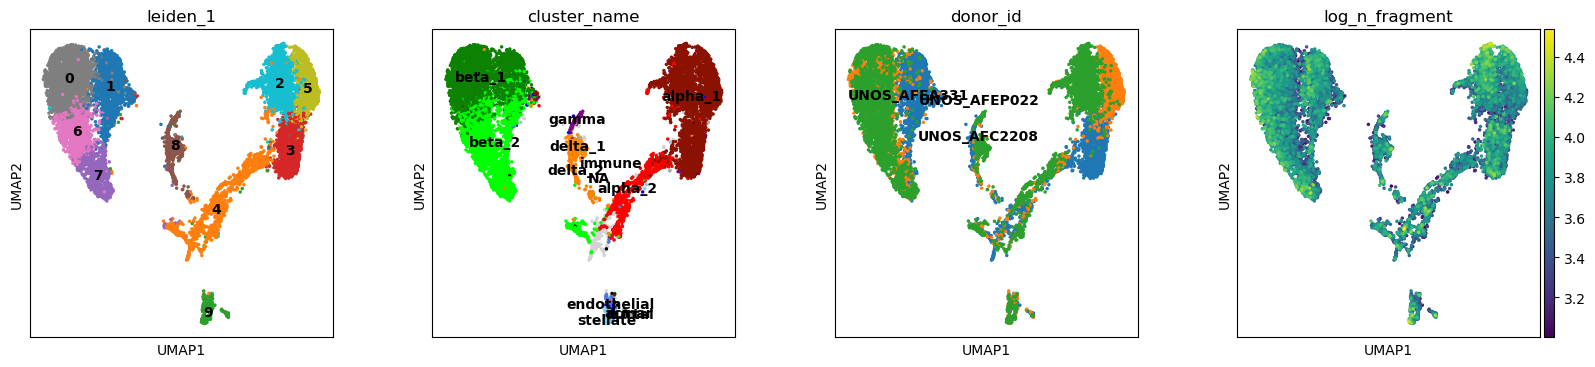

In [184]:
# Plot with fig size 4,4 
with plt.rc_context({'figure.figsize': (4, 4)}):
    sc.pl.umap(adata, color=["leiden_1", "cluster_name", "donor_id", "log_n_fragment"], legend_loc="on data", s=25)

In [185]:
# Creat UMAP from paper
adata.obsm["X_umap_paper"] = adata.obs[["UMAP1", "UMAP2"]].values

/cellar/users/aklie/opt/miniconda3/envs/scverse-lite-py39/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
2024-06-04 08:23:21 - WARNING - posx and posy should be finite values
2024-06-04 08:23:21 - WARNING - posx and posy should be finite values


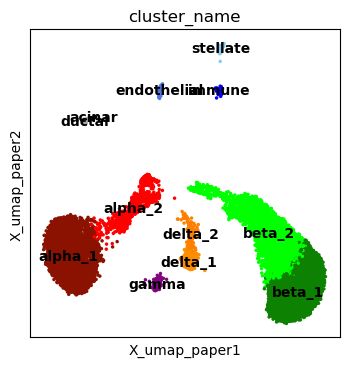

In [186]:
# Plot with fig size 4,4 
with plt.rc_context({'figure.figsize': (4, 4)}):
    sc.pl.embedding(adata, basis="X_umap_paper", color="cluster_name", legend_loc="on data", s=25)

# Remove cells without annotation

In [203]:
adata_filt = adata[adata.obs["cluster_name"].notnull()].copy()
adata_filt

AnnData object with n_obs × n_vars = 12806 × 606219
    obs: 'sample', 'log_n_fragment', 'tsse', 'leiden_1', 'donor_id', 'tissue', 'sex', 'age', 'bmi', 'n_fragment', 'frac_dup', 'frac_mito', 'doublet_probability', 'doublet_score', 'UMAP1', 'UMAP2', 'cluster_name', 'sample_id', 'barcode', 'duplicated_reads', 'total_sequenced_reads', 'unique_usable_reads', 'unique_mito_reads', 'reads_in_peaks', 'reads_in_promoters', 'tss_used', 'frac_reads_in_peaks', 'frac_reads_in_promoters', 'frac_promoters_used', 'frac_mito_reads', 'frac_duplicated_reads', 'sample_id_paper_qc', 'barcode_paper_qc', 'donor_id_paper_qc'
    var: 'count', 'selected'
    uns: 'AnnDataSet', 'reference_sequences', 'spectral_eigenvalue', 'cluster_name_colors', 'leiden_1_colors', 'donor_id_colors'
    obsm: 'X_spectral', 'X_umap', 'X_umap_paper'
    obsp: 'distances'

/cellar/users/aklie/opt/miniconda3/envs/scverse-lite-py39/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
2024-06-04 08:29:29 - WARNING - posx and posy should be finite values
2024-06-04 08:29:29 - WARNING - posx and posy should be finite values


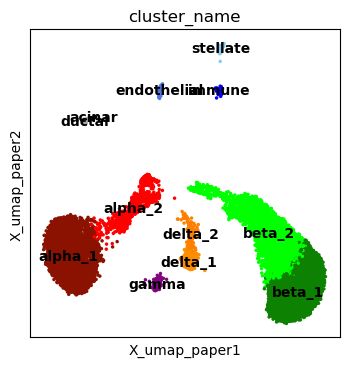

In [204]:
# Plot with fig size 4,4 
with plt.rc_context({'figure.figsize': (4, 4)}):
    sc.pl.embedding(adata, basis="X_umap_paper", color="cluster_name", legend_loc="on data", s=25)

In [205]:
# Save the filtered adata
adata_filt.write(os.path.join(outdir_path, "paper_annotations.h5ad"))

In [207]:
# Save two column .txt file with barcode (index) and cluster_name (no header)
adata_filt.obs[["cluster_name"]].to_csv(os.path.join(outdir_path, "paper_annotations.txt"), sep="\t", header=False)

# Inspect those cells that do not overlap

## One's we kept

In [211]:
# Grab cells in our dataset that are not in cell_qc
adata_unannotated = adata[~adata.obs["cluster_name"].notnull()].copy()
adata_unannotated

AnnData object with n_obs × n_vars = 1053 × 606219
    obs: 'sample', 'log_n_fragment', 'tsse', 'leiden_1', 'donor_id', 'tissue', 'sex', 'age', 'bmi', 'n_fragment', 'frac_dup', 'frac_mito', 'doublet_probability', 'doublet_score', 'UMAP1', 'UMAP2', 'cluster_name', 'sample_id', 'barcode', 'duplicated_reads', 'total_sequenced_reads', 'unique_usable_reads', 'unique_mito_reads', 'reads_in_peaks', 'reads_in_promoters', 'tss_used', 'frac_reads_in_peaks', 'frac_reads_in_promoters', 'frac_promoters_used', 'frac_mito_reads', 'frac_duplicated_reads', 'sample_id_paper_qc', 'barcode_paper_qc', 'donor_id_paper_qc'
    var: 'count', 'selected'
    uns: 'AnnDataSet', 'reference_sequences', 'spectral_eigenvalue', 'cluster_name_colors', 'leiden_1_colors', 'donor_id_colors'
    obsm: 'X_spectral', 'X_umap', 'X_umap_paper'
    obsp: 'distances'

In [218]:
adata.obs["annotation_status"] = adata.obs["cluster_name"].notnull().replace({True: "annotated", False: "unannotated"})
adata.obs["annotation_status"].value_counts()

annotated      12806
unannotated     1053
Name: annotation_status, dtype: int64

/cellar/users/aklie/opt/miniconda3/envs/scverse-lite-py39/lib/python3.9/site-packages/scanpy/plotting/_anndata.py:840: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(
/cellar/users/aklie/opt/miniconda3/envs/scverse-lite-py39/lib/python3.9/site-packages/scanpy/plotting/_anndata.py:840: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  ax = sns.violinplot(
/cellar/users/aklie/opt/miniconda3/envs/scverse-lite-py39/lib/python3.9/site-packages/scanpy/plotting/_anndata.py:840: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(
/cellar/users/aklie/opt/miniconda3/envs/scverse-lite-py39/lib/python3.9

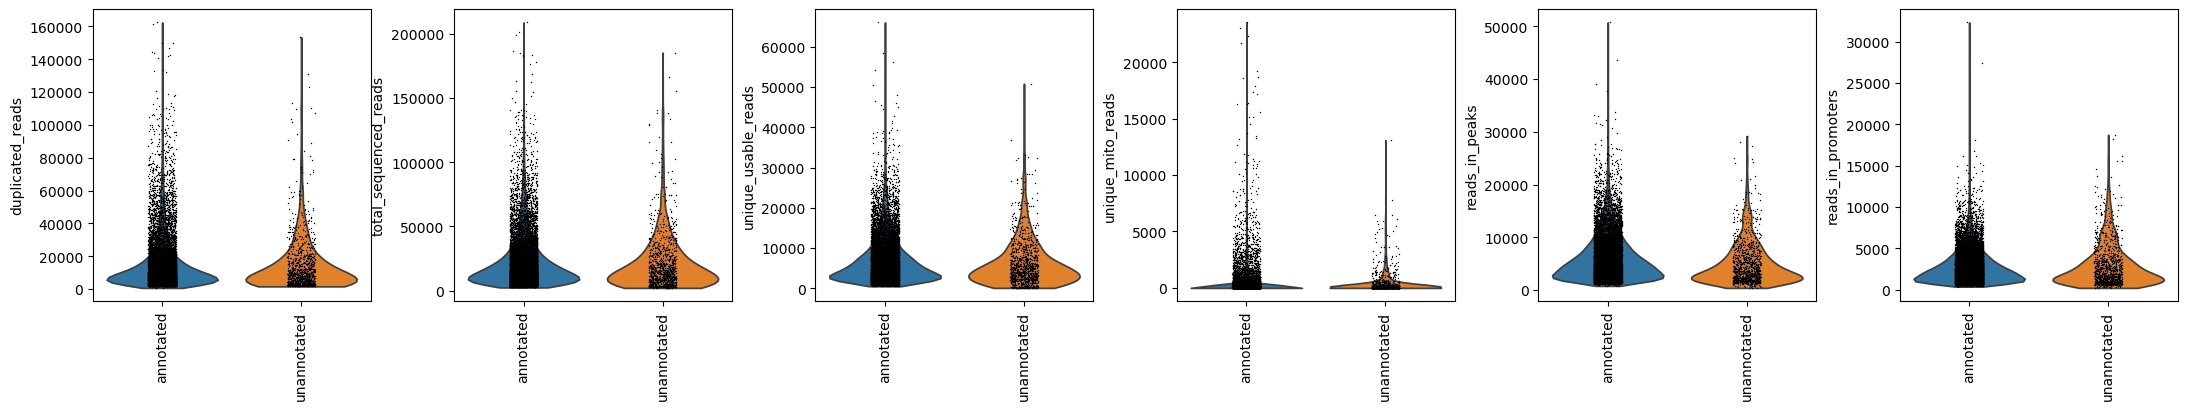

/cellar/users/aklie/opt/miniconda3/envs/scverse-lite-py39/lib/python3.9/site-packages/scanpy/plotting/_anndata.py:840: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(
/cellar/users/aklie/opt/miniconda3/envs/scverse-lite-py39/lib/python3.9/site-packages/scanpy/plotting/_anndata.py:840: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  ax = sns.violinplot(
/cellar/users/aklie/opt/miniconda3/envs/scverse-lite-py39/lib/python3.9/site-packages/scanpy/plotting/_anndata.py:840: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(
/cellar/users/aklie/opt/miniconda3/envs/scverse-lite-py39/lib/python3.9

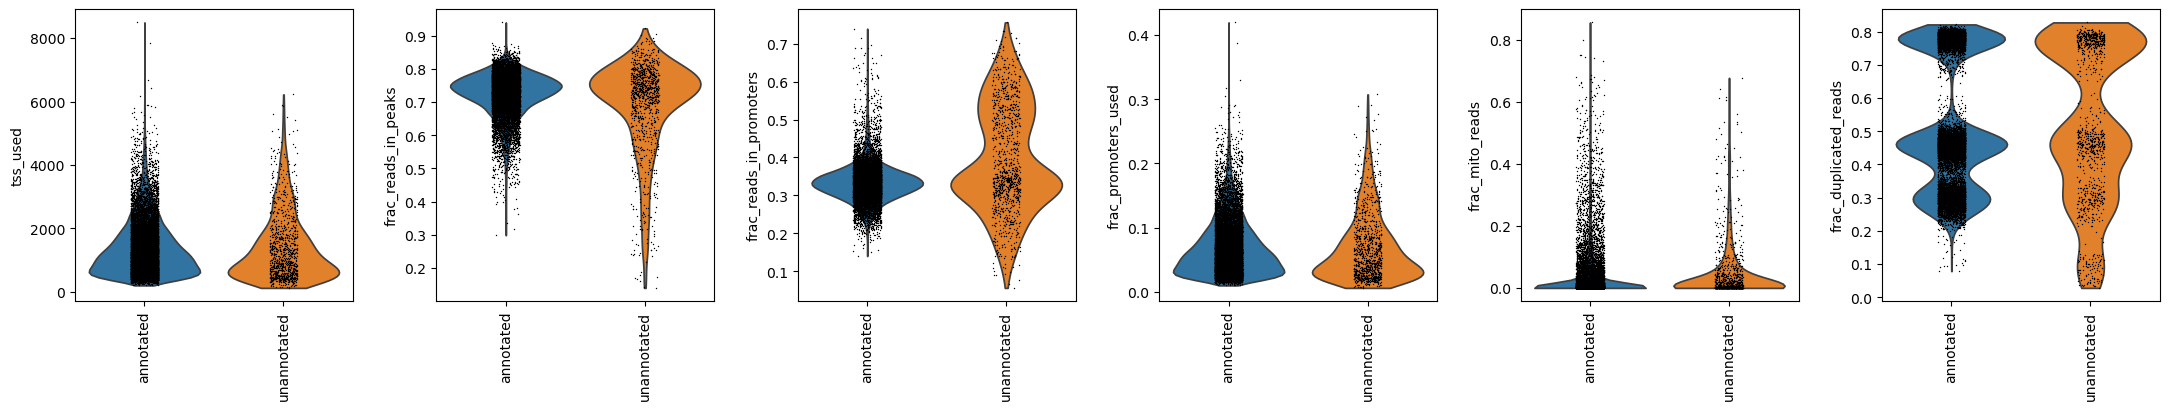

In [227]:
# Check n_fragment between annotated and unannotated
metric_cols = ['duplicated_reads', 'total_sequenced_reads', 'unique_usable_reads', 'unique_mito_reads', 'reads_in_peaks', 'reads_in_promoters', 'tss_used', 'frac_reads_in_peaks', 'frac_reads_in_promoters', 'frac_promoters_used', 'frac_mito_reads', 'frac_duplicated_reads']
with plt.rc_context({'figure.figsize': (4, 4)}):
    sc.pl.violin(adata, keys=metric_cols[:6], groupby="annotation_status", rotation=90)
    sc.pl.violin(adata, keys=metric_cols[6:], groupby="annotation_status", rotation=90)

#

## One's we missed

In [234]:
# 
missed = cell_annotations[~cell_annotations.index.isin(adata.obs.index)].index
kept = cell_annotations[cell_annotations.index.isin(adata.obs.index)].index

In [239]:
# filter cell_qc for both missed and kept and add new column
cell_qc_filt = cell_qc.loc[missed.to_list() + kept.to_list()].copy()
cell_qc_filt["missed"] = cell_qc_filt.index.isin(missed)
cell_qc_filt["missed"] = cell_qc_filt["missed"].replace({True: "missed", False: "kept"})
cell_qc_filt

,duplicated_reads,total_sequenced_reads,unique_usable_reads,unique_mito_reads,reads_in_peaks,reads_in_promoters,tss_used,frac_reads_in_peaks,frac_reads_in_promoters,frac_promoters_used,frac_mito_reads,frac_duplicated_reads,sample_id,barcode,donor_id,missed
UNOS_AFC2208#AGACACCTACTCGCTAGAGCCTTAGGTTG,1846,3752,1906,0,1261,487,273,0.661595,0.255509,0.013487,0.000000,0.492004,Islet1,AGACACCTACTCGCTAGAGCCTTAGGTTG,UNOS_AFC2208,missed
UNOS_AFC2208#AGACACCTACTCGCTAGTAAGGAGGTACT,185852,230040,43700,488,31983,14900,5768,0.731876,0.340961,0.284952,0.011044,0.807912,Islet1,AGACACCTACTCGCTAGTAAGGAGGTACT,UNOS_AFC2208,missed
UNOS_AFC2208#AGACACCTACTGAGCGAAGGAGTACAGGA,128144,161336,33148,44,22476,10762,4563,0.678050,0.324665,0.225422,0.001326,0.794268,Islet1,AGACACCTACTGAGCGAAGGAGTACAGGA,UNOS_AFC2208,missed
UNOS_AFC2208#AGACACCTACTGAGCGATCTGAGTGTACT,319488,405154,85662,4,59714,26884,8052,0.697089,0.313838,0.397787,0.000047,0.788559,Islet1,AGACACCTACTGAGCGATCTGAGTGTACT,UNOS_AFC2208,missed
UNOS_AFC2208#AGACACCTACTGAGCGCCTAGAGTTATAG,122190,150944,28750,4,21362,11715,4523,0.743026,0.407478,0.223446,0.000139,0.809506,Islet1,AGACACCTACTGAGCGCCTAGAGTTATAG,UNOS_AFC2208,missed
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
UNOS_AFEP022#TCCGGAGATGCAGCTACTCTCTATTATAGCCT,17358,33778,16174,246,13223,5548,2650,0.761781,0.319622,0.130916,0.013974,0.478832,Islet3,TCCGGAGATGCAGCTACTCTCTATTATAGCCT,UNOS_AFEP022,kept
UNOS_AFEP022#TCCGGAGATGCAGCTATATCCTCTTATAGCCT,6732,13284,5744,808,5401,2296,1180,0.802288,0.341058,0.058295,0.107162,0.432400,Islet3,TCCGGAGATGCAGCTATATCCTCTTATAGCCT,UNOS_AFEP022,kept
UNOS_AFEP022#TCCGGAGATGCAGCTATCGACTAGATAGAGGC,2608,5394,2580,206,2118,1123,614,0.812117,0.430598,0.030333,0.073205,0.478309,Islet3,TCCGGAGATGCAGCTATCGACTAGATAGAGGC,UNOS_AFEP022,kept
UNOS_AFEP022#TCCGGAGATGCAGCTATTCTAGCTCAGGACGT,3202,5940,2736,2,2267,998,552,0.707995,0.311680,0.027270,0.000624,0.460606,Islet3,TCCGGAGATGCAGCTATTCTAGCTCAGGACGT,UNOS_AFEP022,kept


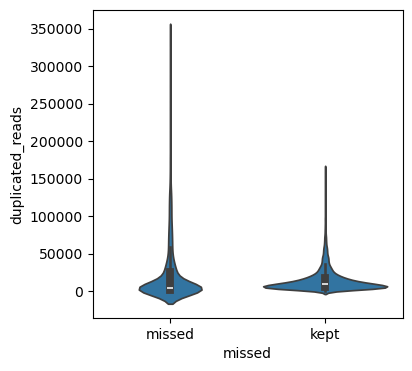

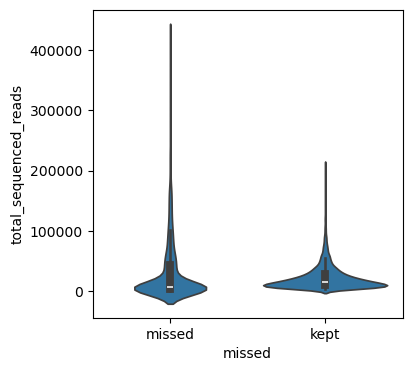

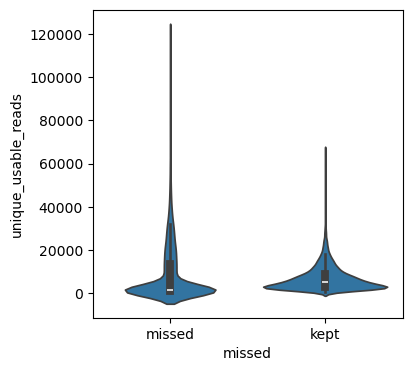

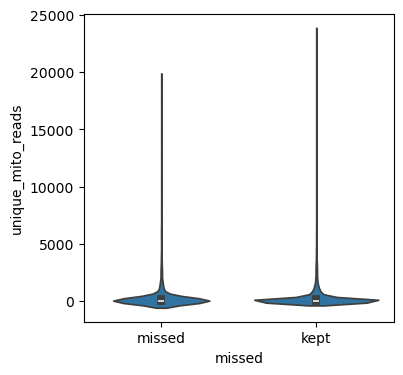

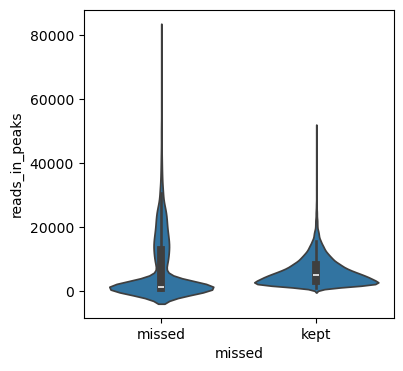

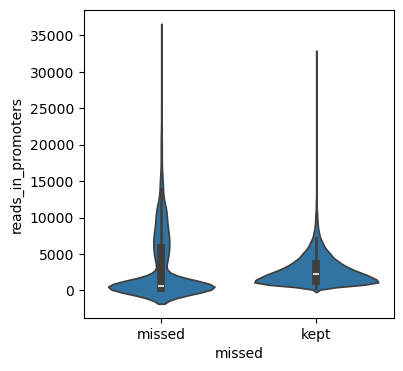

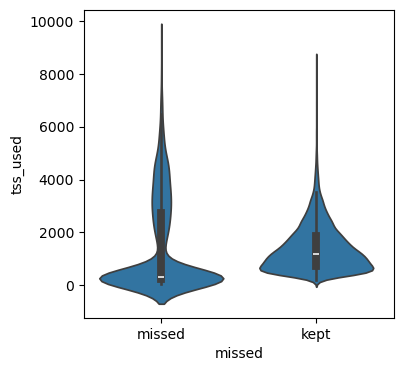

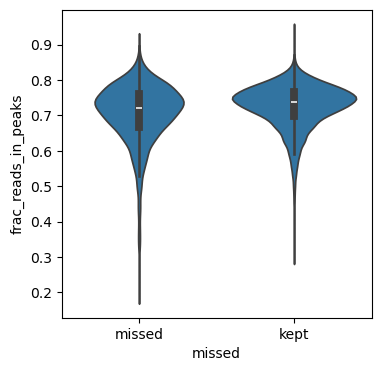

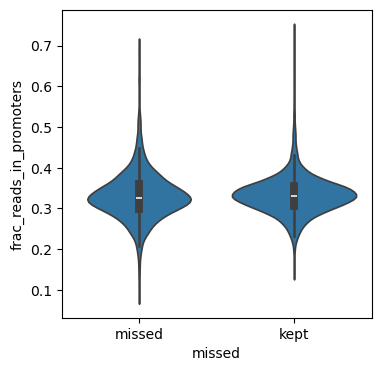

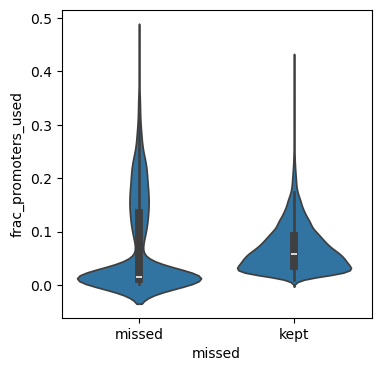

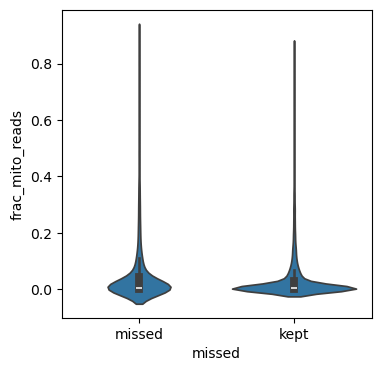

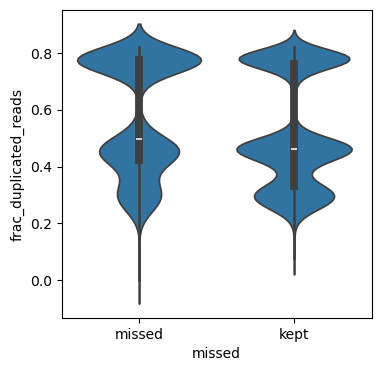

In [240]:
# Plot metrics using seaborn
metric_cols = ['duplicated_reads', 'total_sequenced_reads', 'unique_usable_reads', 'unique_mito_reads', 'reads_in_peaks', 'reads_in_promoters', 'tss_used', 'frac_reads_in_peaks', 'frac_reads_in_promoters', 'frac_promoters_used', 'frac_mito_reads', 'frac_duplicated_reads']
with plt.rc_context({'figure.figsize': (4, 4)}):
    for col in metric_cols:
        sns.violinplot(data=cell_qc_filt, x="missed", y=col)
        plt.show()

# Recluster

In [189]:
#
adata_pp = adata.copy()
sc.pp.normalize_total(adata_pp, target_sum=1e4)
sc.pp.log1p(adata_pp)
sc.pp.highly_variable_genes(adata_pp, min_mean=0.01, min_disp=0.25)

In [191]:
adata_pp.var["highly_variable"].value_counts()

False    550931
True      55288
Name: highly_variable, dtype: int64

In [192]:
adata_pp = adata_pp[:, adata_pp.var.highly_variable].copy()
adata_pp

AnnData object with n_obs × n_vars = 13859 × 55288
    obs: 'sample', 'log_n_fragment', 'tsse', 'leiden_1', 'donor_id', 'tissue', 'sex', 'age', 'bmi', 'n_fragment', 'frac_dup', 'frac_mito', 'doublet_probability', 'doublet_score', 'UMAP1', 'UMAP2', 'cluster_name', 'sample_id', 'barcode', 'duplicated_reads', 'total_sequenced_reads', 'unique_usable_reads', 'unique_mito_reads', 'reads_in_peaks', 'reads_in_promoters', 'tss_used', 'frac_reads_in_peaks', 'frac_reads_in_promoters', 'frac_promoters_used', 'frac_mito_reads', 'frac_duplicated_reads', 'sample_id_paper_qc', 'barcode_paper_qc', 'donor_id_paper_qc'
    var: 'count', 'selected', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'AnnDataSet', 'reference_sequences', 'spectral_eigenvalue', 'cluster_name_colors', 'leiden_1_colors', 'donor_id_colors', 'log1p', 'hvg'
    obsm: 'X_spectral', 'X_umap', 'X_umap_paper'
    obsp: 'distances'

In [193]:
adata_pp.obs["usable_counts"] = adata_pp.X.sum(axis=1)
adata_pp.obs["log_usable_counts"] = np.log1p(adata_pp.obs["usable_counts"])

In [ ]:
#sc.pp.regress_out(adata_pp, keys=["log_usable_counts"])

In [195]:
sc.pp.scale(adata_pp)
sc.tl.pca(adata_pp, zero_center=True, svd_solver='arpack', random_state=1234)

In [197]:
sc.pp.neighbors(adata_pp, n_neighbors=30, random_state=1234, use_rep="X_pca")

In [198]:
sc.tl.umap(adata_pp, min_dist=0.3, spread=1.0, random_state=1234)

In [199]:
sc.tl.leiden(adata_pp, resolution=1.5, key_added="leiden_1.5", random_state=1234)

/cellar/users/aklie/opt/miniconda3/envs/scverse-lite-py39/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/cellar/users/aklie/opt/miniconda3/envs/scverse-lite-py39/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/cellar/users/aklie/opt/miniconda3/envs/scverse-lite-py39/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


<Figure size 1932x400 with 0 Axes>

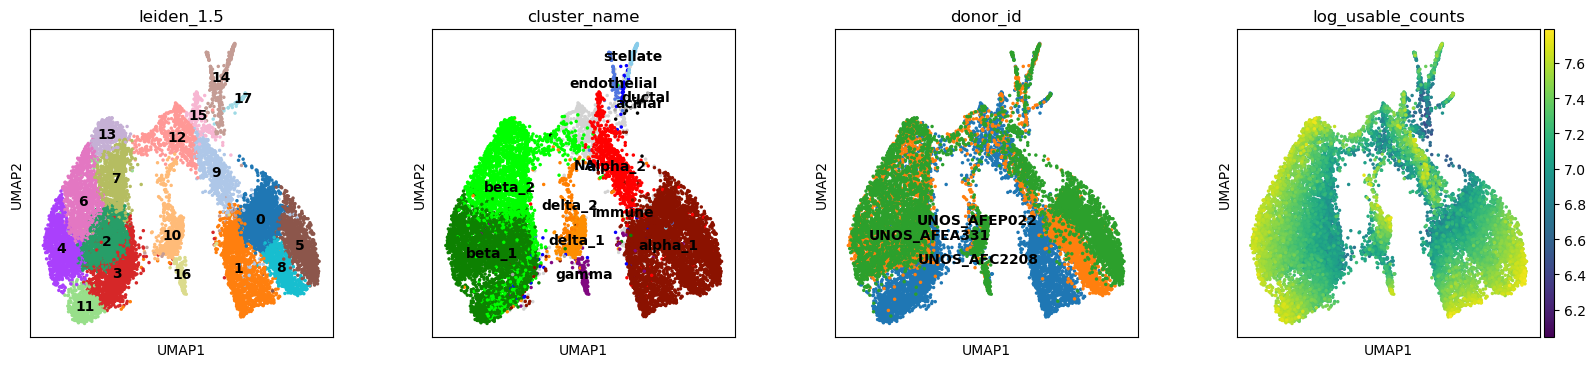

In [201]:
# Plot with fig size 4,4 
with plt.rc_context({'figure.figsize': (4, 4)}):
    sc.pl.umap(adata_pp, color=["leiden_1.5", "cluster_name", "donor_id", "log_usable_counts"], legend_loc="on data", s=25)

In [ ]:
snap.pp.harmony(adata, batch="donor_id", max_iter_harmony=20)

In [ ]:
# Harmony correct the matrix based on donor_id
snap.pp.harmony(adata, batch="donor_id", max_iter_harmony=20)

In [110]:
# Select features
snap.pp.select_features(adata, n_features=50000, blacklist=blacklist_path)

2024-06-03 12:43:00 - INFO - Selected 249495 features.


In [111]:
# Spectral embedding
snap.tl.spectral(adata, random_state=1234)

In [112]:
# Remove the first dimension of adata.obsm["spectral"]
old_spectral = adata.obsm['X_spectral'].copy()
adata.obsm['X_spectral'] = adata.obsm['X_spectral'][:, 1:]

In [119]:
# Harmony correct the matrix based on donor_id
snap.pp.harmony(adata, batch="donor_id", max_iter_harmony=20)

2024-06-04 08:05:18,637 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2024-06-04 08:05:18 - INFO - Computing initial centroids with sklearn.KMeans...
2024-06-04 08:05:18 - INFO - Computing initial centroids with sklearn.KMeans...
2024-06-04 08:05:22,697 - harmonypy - INFO - sklearn.KMeans initialization complete.
2024-06-04 08:05:22 - INFO - sklearn.KMeans initialization complete.
2024-06-04 08:05:22,915 - harmonypy - INFO - Iteration 1 of 20
2024-06-04 08:05:22 - INFO - Iteration 1 of 20
2024-06-04 08:05:28,835 - harmonypy - INFO - Iteration 2 of 20
2024-06-04 08:05:28 - INFO - Iteration 2 of 20
2024-06-04 08:05:34,740 - harmonypy - INFO - Iteration 3 of 20
2024-06-04 08:05:34 - INFO - Iteration 3 of 20
2024-06-04 08:05:40,335 - harmonypy - INFO - Iteration 4 of 20
2024-06-04 08:05:40 - INFO - Iteration 4 of 20
2024-06-04 08:05:45,845 - harmonypy - INFO - Iteration 5 of 20
2024-06-04 08:05:45 - INFO - Iteration 5 of 20
2024-06-04 08:05:51,771 - harmonypy - IN

In [121]:
# Run neighbors
#sc.pp.neighbors(adata, n_pcs=adata.obsm["X_spectral"].shape[1], n_neighbors=30, random_state=1234, use_rep="X_spectral")
sc.pp.neighbors(adata, n_neighbors=30, random_state=1234, use_rep="X_spectral_harmony")

In [122]:
# Perform higher resolution clustering
sc.tl.leiden(adata, resolution=0.2, key_added="leiden_0.2", random_state=1234)
sc.tl.leiden(adata, resolution=0.5, key_added="leiden_0.5", random_state=1234)
sc.tl.leiden(adata, resolution=0.8, key_added="leiden_0.8", random_state=1234)
sc.tl.leiden(adata, resolution=1, key_added="leiden_1", random_state=1234)
sc.tl.leiden(adata, resolution=1.5, key_added="leiden_1.5", random_state=1234)
sc.tl.leiden(adata, resolution=2.5, key_added="leiden_2.5", random_state=1234)

In [123]:
sc.tl.umap(adata, min_dist=0.3, spread=1.0, random_state=1234)

/cellar/users/aklie/opt/miniconda3/envs/scverse-lite-py39/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/cellar/users/aklie/opt/miniconda3/envs/scverse-lite-py39/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/cellar/users/aklie/opt/miniconda3/envs/scverse-lite-py39/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


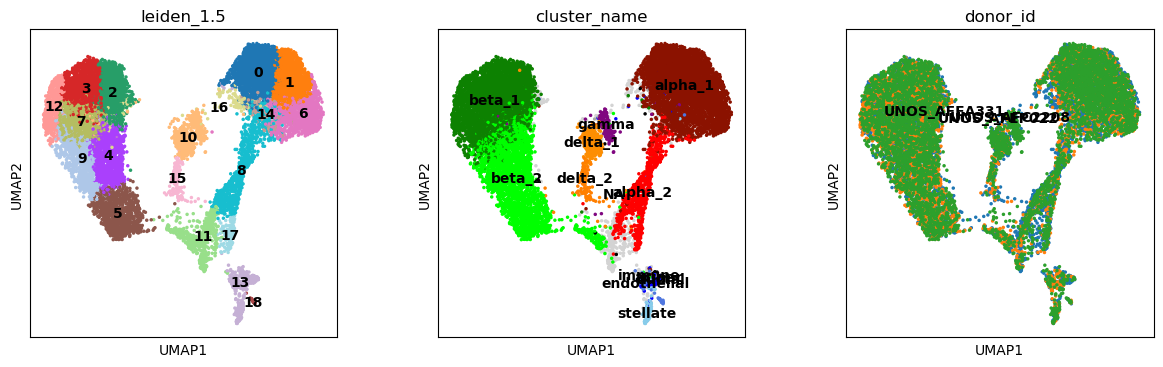

In [124]:
# Plot with fig size 4,4 
with plt.rc_context({'figure.figsize': (4, 4)}):
    sc.pl.umap(adata, color=["leiden_1.5", "cluster_name", "donor_id"], legend_loc="on data", s=25)

# Assign annotations to cells currently missing them

In [125]:
# Get the proportions of each cell type (based on cluster_name) for each leiden_2 cluster
proportions = adata.obs.groupby(["leiden_1.5", "cluster_name"]).size().unstack().fillna(0)
proportions = proportions.div(proportions.sum(axis=1), axis=0)
proportions

cluster_name,beta_1,beta_2,alpha_1,alpha_2,delta_1,delta_2,gamma,ductal,acinar,stellate,endothelial,immune
leiden_1.5,,,,,,,,,,,,
0,0.000000,0.000000,0.990093,0.001166,0.000583,0.000000,0.002331,0.000583,0.000000,0.000000,0.000000,0.005245
1,0.000000,0.000000,0.999244,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000756
2,0.920444,0.071230,0.000000,0.000000,0.000925,0.000000,0.001850,0.000000,0.000000,0.000000,0.000000,0.005550
3,0.980072,0.015399,0.000000,0.000000,0.000906,0.000000,0.000000,0.000000,0.000906,0.000906,0.000000,0.001812
4,0.078413,0.919742,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.001845
5,0.000000,0.994835,0.000000,0.001033,0.000000,0.003099,0.000000,0.000000,0.001033,0.000000,0.000000,0.000000
6,0.000000,0.000000,0.984799,0.009772,0.000000,0.000000,0.004343,0.000000,0.000000,0.000000,0.001086,0.000000
7,0.861502,0.136150,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.002347
8,0.000000,0.004950,0.236386,0.745050,0.000000,0.007426,0.000000,0.000000,0.001238,0.000000,0.002475,0.002475


In [ ]:
# Read this list of highly variable windows
path__hvw = "/cellar/users/aklie/data/datasets/Chiou2021_islet_snATAC-seq/ref/publication/islet.hvw"
hvw = pd.read_csv(path__hvw, header=None)[0]

# Split by ":" and "-" to get chrom, start, end
hvw = hvw.str.split("[:-]", expand=True)
hvw.columns = ["chrom", "start", "end"]
hvw["start"] = hvw["start"].astype(int)
hvw["end"] = hvw["end"].astype(int)

# Add in "chr" to chrom
hvw["chrom"] = "chr" + hvw["chrom"]

# save to bed file
hvw_bed = "/cellar/users/aklie/data/datasets/Chiou2021_islet_snATAC-seq/ref/publication/islet.hvw.bed"
hvw.to_csv(hvw_bed, sep="\t", header=False, index=False)